# Method 1: Manual analysis of threat reports
This notebook supports manual threat report analysis by scanning the spreadsheet and enriching the data. The enriched data can be filtered on sector and the actors and TTPs will be ranked. These ranked TTPs can be mapped to controls.

![Diagram representation of method 1](./docs/images/Method1.png)

## 1. Determine relevant threats  and actors
### 1.1. Scan spreadsheet with skimming results 
#### 1.1.1. Build actor and threat list

In [103]:
import pandas as pd

SECTOR = 'Government'
file = "Threat reports.xlsx"
reports = pd.read_excel(file,sheet_name="Threat reports")

In [104]:
# Function to transform a list to unique (case insensitive) values
def unique(lst):
    result=[]
    marker = set()

    for l in lst:
        ll = l.lower()
        if ll not in marker:   # test presence
            marker.add(ll)
            result.append(l)   # preserve order

    return result

# Build the lists
year = 2021

# Filter on one year
reports=reports[reports['reported year'] == year]

report_threats = reports['threats'].dropna().apply(lambda x: x.split(", "))
threats_mentions = pd.Series([t for l in report_threats for t in l if t != ""])
threatlist = unique(threats_mentions)

report_actors = reports['actors'].dropna().apply(lambda x: x.split(", "))
actor_mentions = pd.Series([t for l in report_actors for t in l if t != ""])
actorlist = unique(actor_mentions)

print(len(threatlist),"Threats:\n",threatlist)
print(len(actorlist),"Threat actors:\n",actorlist)

34 Threats:
 ['ransomware', 'crypto malware', 'scams', 'adware', 'fleeceware', 'phishing', 'coinminers', 'information stealers', 'remote access trojan', 'technical support cams', 'rootkits', 'supply chain attack', 'remote code execution', 'business email compromise', 'brand abuse', 'data exposure on code repositories', 'targeted threats on remote work', 'DDoS', 'proxy shell', 'account compromise', 'system compromise', 'botnet', 'server access', 'credential harvesting', 'misconfiguration', 'malicious insider', 'vulnerability exploitation', 'brute force', 'password spraying', 'banking trojan', 'network pivot', 'network infrastructure compromise', 'local code execution', 'use of stolen credentials']
73 Threat actors:
 ['LuckyMouse', 'Mustang Panda', 'Gamaredon', 'Promethium', 'HAFNIUM', 'Wizard Spider', 'Bitwise Spider', 'Carbon Spider', 'Pinchy Spider', 'Pioneer Kitten', 'Deus', 'BlackShadow', 'Moses Staff', 'Nemesis Kitten', 'Wicked Panda', 'Doppel Spider', 'Aquatic Panda', 'Fancy Bear'

#### 1.1.2. Visualize quarterly time coverage

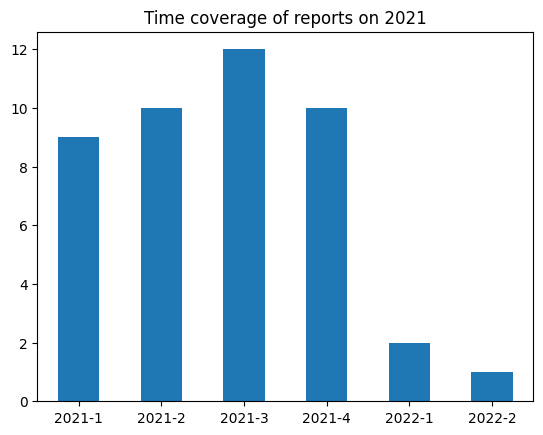

In [105]:
# Convert a 2d list to 1d
def to_1D(series):
 return pd.Series([x for _list in series for x in _list if len(x) > 1]) # Convert column of lists to one list and remove single character values

quarters = to_1D(reports['quarter'].dropna().apply(lambda x: x.split(", "))).value_counts().sort_index()
fig = quarters.plot(kind='bar',rot=0, title='Time coverage of reports on {}'.format(year))

#### Observations
It can be seen that not all reports report on a full calendar year. Some reports do not start in Q1, but start in Q3 and report on the following 4 quarters, like the ENISA threat landscape. In other cases, the report does not report on 4 quarters. For example, Bugcrowd reports up and until Q3, since the report is released before the end of the year.

### 1.2. Scan PDFs on threats and actors
Scan the PDFs on the actors and threats from the spreadsheet and count the number of occurences.

#### 1.2.1. Initialize dictionaries and functions
Initialize dictionaries and define a preprocessing function whichs converts to lowercase and removes punctuations. 

In [106]:
import PyPDF2
import os
import re

report_folder = "reports\\2021"
report_list = [file for file in os.listdir(report_folder) if file.endswith(".pdf")]

## Init threat dictionary to count occurences of threats per report
report_threats = {}  
report_actors = {}

for i in report_list:
    threat_dict = {}
    for j in threatlist:
        threat_dict[j] = 0    
    report_threats[i] = threat_dict

for i in report_list:
    actor_dict = {}
    for k in actorlist:
        actor_dict[k] = 0
    report_actors[i] = actor_dict

def preprocess(text):
    text_lower = re.sub(r"[^a-zA-Z0-9 ]","",text.lower())
    return text_lower

#### 1.2.2. Scan threat report PDFs
Threat reports are scanned on the threats and actors defined in the spreadsheet. The number of occurences is noted.

In [107]:
import re

text_dict = {}

for file in report_list:
    print("Processing: ",file)

    reader = PyPDF2.PdfFileReader(report_folder+"\\"+file,strict=False)
    raw_text = ""
    for page_number in range(0, reader.numPages):
        page = reader.getPage(page_number)
        raw_text += page.extractText()
    text_dict[file] = {"raw": raw_text, "processed": preprocess(raw_text)}

Processing:  Blackberry.pdf
Processing:  Bugcrowd.pdf
Processing:  Crowdstrike.pdf
Processing:  CTM360.pdf
Processing:  Deepwatch.pdf
Processing:  ENISA.pdf
Processing:  Fortinet-2021H1.pdf
Processing:  Fortinet-2021H2.pdf
Processing:  IBM.pdf
Processing:  Microsoft.pdf
Processing:  PaloAltoNetworks.pdf
Processing:  Rapid7.pdf
Processing:  Verizon.pdf


#### 1.2.3. Convert reports to .txt for later testing

In [108]:
from pathlib import Path, PureWindowsPath

txt_filepath = Path("reports_txt/"+str(year))

for file,values in text_dict.items():
    text = values["raw"]
    filenm = file.replace(".pdf",".txt")
    to_write = txt_filepath / filenm
    with open(to_write,'w',encoding='utf-8') as f:
        f.write(text)

#### 1.2.4. Count occurences of terms in reports

In [109]:
# Count occurences of terms in reports
for file,values in text_dict.items():
    text = values["processed"]
    for threat in threatlist:
        report_threats[file][threat] = text.count(threat.lower())
    for actor in actorlist:
        report_actors[file][actor] = text.count(actor.lower()) 

threats_df = pd.DataFrame(report_threats)
actors_df = pd.DataFrame(report_actors)

### 1.3. Process and first data enrichment
#### 1.3.1. Gather data from public sources
Retrieve extra data from ETDA to obtain synonyms from actors so the results can be merged on synonyms.

In [110]:
# Get synonyms of threat actors from ETDA
import pandas as pd
import requests

# Retrieve data in json format
etda_actors = requests.get('https://apt.etda.or.th/cgi-bin/getcard.cgi?g=all&o=j')
data = etda_actors.json()

actor_list = []

for actor in data['values']:
    actor_dict = {}
    actor_dict['actor'] = actor['actor']
    actor_dict['alternate_names'] = [x['name'] for x in actor['names']]
    actor_list.append(actor_dict)

synonym_df = pd.DataFrame(actor_list)
synonym_df

,actor,alternate_names
0,Big Panda,[Big Panda]
1,Boulder Bear,[Boulder Bear]
2,Clockwork Spider,[Clockwork Spider]
3,Corsair Jackal,"[Corsair Jackal, TunisianCyberArmy]"
4,Dextorous Spider,[Dextorous Spider]
...,...,...
424,UNC1878,[UNC1878]
425,[Vault 7/8],[[Vault 7/8]]
426,Yanbian Gang,[Yanbian Gang]
427,Yingmob,[Yingmob]


#### 1.3.2. Merge results of synonyms from actors

In [111]:
# Transpose dataframe so that the actors are columns
actors_df_transposed = actors_df.T

# Function to find synonyms of actors and sum the results
def sum_synonyms(df, synonyms):
    summed_df = df
    word_matches = {}
    for actor in df.columns:
        lst = []
        for _, row in synonyms.iterrows():
            keyname = row['actor']
            synonym = row['alternate_names']
            match = [x for x in synonym if actor == x]
            if actor == keyname or match:
                match = ' '.join(map(str, match))
                try:
                    word_matches[keyname].append(match)
                except:
                    word_matches[keyname] = [match]

    # Combine results of alternative names
    for keyname, matches in word_matches.items():
        summed_df[keyname] = df[matches].sum(axis=1)
    
    # Return the summed columns
    return summed_df[list(word_matches.keys())]

actors_df = sum_synonyms(actors_df_transposed,synonym_df).T


In [112]:
actors_df

,Blackberry.pdf,Bugcrowd.pdf,Crowdstrike.pdf,CTM360.pdf,Deepwatch.pdf,ENISA.pdf,Fortinet-2021H1.pdf,Fortinet-2021H2.pdf,IBM.pdf,Microsoft.pdf,PaloAltoNetworks.pdf,Rapid7.pdf,Verizon.pdf
"Emissary Panda, APT 27, LuckyMouse, Bronze Union",0,0,0,0,0,0,0,0,0,0,0,0,0
"Mustang Panda, Bronze President",0,0,0,0,0,2,0,0,0,0,0,0,0
"Promethium, StrongPity",2,0,0,0,0,0,0,0,0,0,0,0,0
"Wizard Spider, Gold Blackburn",0,0,11,0,0,0,0,0,5,0,0,0,0
"Carbanak, Anunak",0,0,1,0,0,0,0,0,0,0,0,0,0
"Pinchy Spider, Gold Southfield",0,0,1,0,0,2,0,0,0,0,0,0,0
"Parisite, Fox Kitten, Pioneer Kitten",0,0,1,0,0,0,0,0,0,0,0,0,0
Agrius,0,0,1,0,0,0,0,0,0,0,0,0,0
Moses Staff,0,0,1,0,0,3,0,0,0,0,0,0,0
"DEV-0270, Nemesis Kitten",0,0,8,0,0,0,0,0,0,0,0,0,0


#### 1.3.3. Normalize data and plots
Since the absolute number of hits cannot be compared between reports, due to differences in report lengths and the number of words, the data is normalized using the minmax normalization.

In [113]:
def normalize(df):
    return (df-df.min())/(df.max()-df.min())

normalized_threats = normalize(threats_df)
normalized_actors = normalize(actors_df)

<Axes: >

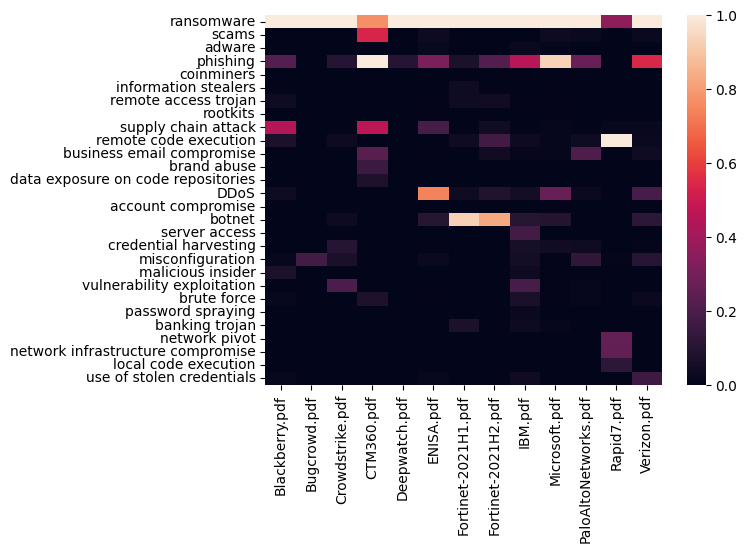

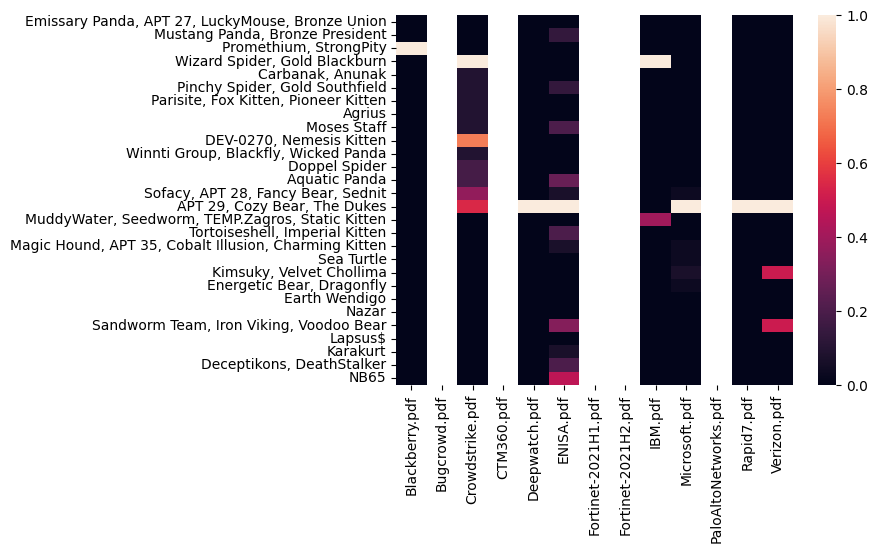

In [114]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.figure()
sns.heatmap(normalized_threats.loc[~(normalized_threats==0).all(axis=1)], yticklabels=True)

plt.figure()
sns.heatmap(normalized_actors.loc[~(normalized_actors==0).all(axis=1)], yticklabels=True)


# fig = plt.figure()
# threat_occurences = normalized_threats.gt(0).sum(axis=1)
# threat_occurences.sort_values(inplace=True)
# threat_occurences.nlargest(10).plot(kind="bar",title="Top 10 threats occuring in threat reports")
# plt.ylabel("Number of reports reporting on threat")
# plt.show()

#### 1.3.3. Sum counts

In [115]:
total_count = normalized_actors.sum(axis=1)
reports_mentioned = normalized_actors.gt(0).sum(axis=1)

actors_results = pd.concat([total_count,reports_mentioned],axis=1)
actors_results.columns = ['total_count','reports_mentioned']

print(actors_results.shape)
print(actors_results.sort_values(by='total_count',ascending=False))

(28, 2)
                                                    total_count  \
APT 29, Cozy Bear, The Dukes                           5.545455   
Wizard Spider, Gold Blackburn                          2.000000   
Promethium, StrongPity                                 1.000000   
Sandworm Team, Iron Viking, Voodoo Bear                0.833333   
DEV-0270, Nemesis Kitten                               0.727273   
Kimsuky, Velvet Chollima                               0.566667   
NB65                                                   0.466667   
Sofacy, APT 28, Fancy Bear, Sednit                     0.463636   
Aquatic Panda                                          0.448485   
MuddyWater, Seedworm, TEMP.Zagros, Static Kitten       0.400000   
Moses Staff                                            0.290909   
Pinchy Spider, Gold Southfield                         0.224242   
Deceptikons, DeathStalker                              0.200000   
Tortoiseshell, Imperial Kitten                        

#### Observations:

### 1.4 Enrich data further
#### 1.4.1 Add sector and TTP data
Perform an outer join with the extracted actors and extra data from ETDA and MITRE. These two have been combined in a dataset byh tropChaud, which will be used for this. See [tropChaud.ipynb](tropChaud.ipynb) for exploration and functions for this data.

Since in some cases MITRE had two different group IDs for the same ETDA actor, these TTPs are merged for the same ETDA actor. Within the TTP lists the duplicates are removed.

In [116]:
import pandas as pd

df = pd.read_json('Categorized_Adversary_TTPs.json')
print(df.columns)

enrich_columns = ['etda_name','victim_industries','mitre_attack_ttps']

# Define helper functions

# Retrieve information on an actor
def get_actor_ETDA(actor):
   return df.loc[df['etda_name'] == actor]
                                      
# Retrieve information on a list of actors
def get_actor_list_ETDA(actor_list):
   return df.loc[df['etda_name'].isin(actor_list)]

# Get all industries
def get_industries():
    return to_1D(df['victim_industries']).value_counts().index.to_list()

extracted_actors = actors_results.index.tolist()
actors_extradata = get_actor_list_ETDA(extracted_actors)

actors_extradata = actors_extradata[enrich_columns]
actors_extradata.set_index('etda_name',inplace=True)

actors_enriched = pd.merge(actors_results,actors_extradata,how='left',left_index=True,right_index=True)
actors_enriched.index.name = 'etda_actor_name'


actors_enriched = actors_enriched.groupby(['etda_actor_name']).agg({'total_count': 'first', 'reports_mentioned': 'first', 'victim_industries':'first','mitre_attack_ttps':'sum'}) #apply(lambda df: to_1D(df['mitre_attack_ttps']))
actors_enriched['mitre_attack_ttps'] = actors_enriched['mitre_attack_ttps'].apply(lambda x: pd.Series(x).unique())

actors_enriched


Index(['mitre_attack_id', 'mitre_attack_name', 'mitre_attack_aliases',
       'mitre_attack_created', 'mitre_attack_last_modified', 'mitre_url',
       'etda_id', 'etda_name', 'etda_aliases', 'etda_first_seen', 'etda_url',
       'country', 'motivation', 'victim_industries', 'victim_countries',
       'mitre_attack_ttps'],
      dtype='object')


,total_count,reports_mentioned,victim_industries,mitre_attack_ttps
etda_actor_name,,,,
"APT 29, Cozy Bear, The Dukes",5.545455,6,"[Aerospace, Defense, Education, Energy, Financ...","[T1078.004, T1001.002, T1087, T1562.004, T1560..."
Agrius,0.090909,1,None,[0]
Aquatic Panda,0.448485,2,"[Government, Technology, Telecommunications]","[T1595.002, T1027, T1003.001, T1059.003, T1588..."
"Carbanak, Anunak",0.090909,1,"[Energy, Financial, Food and Agriculture, Heal...","[T1078, T1588.002, T1036.004, T1102.002, T1036..."
"DEV-0270, Nemesis Kitten",0.727273,1,None,[0]
"Deceptikons, DeathStalker",0.200000,1,None,[0]
Doppel Spider,0.181818,1,None,[0]
Earth Wendigo,0.000000,0,None,[0]
"Emissary Panda, APT 27, LuckyMouse, Bronze Union",0.000000,0,"[Aerospace, Aviation, Defense, Education, Emba...","[T1190, T1574.001, T1059.001, T1133, T1547.001..."


#### 1.4.2 Filter on sector

In [117]:
def filter_by_sector(df, sector):
    actors_sector_exploded = df.explode('victim_industries')
    return actors_sector_exploded.loc[actors_sector_exploded['victim_industries'] == sector]

actors_filtered = filter_by_sector(actors_enriched,SECTOR)
actors_filtered

,total_count,reports_mentioned,victim_industries,mitre_attack_ttps
etda_actor_name,,,,
"APT 29, Cozy Bear, The Dukes",5.545455,6,Government,"[T1078.004, T1001.002, T1087, T1562.004, T1560..."
Aquatic Panda,0.448485,2,Government,"[T1595.002, T1027, T1003.001, T1059.003, T1588..."
"Emissary Panda, APT 27, LuckyMouse, Bronze Union",0.000000,0,Government,"[T1190, T1574.001, T1059.001, T1133, T1547.001..."
"Kimsuky, Velvet Chollima",0.566667,2,Government,"[T1059.001, T1594, T1136.001, T1560.001, T1562..."
"Magic Hound, APT 35, Cobalt Illusion, Charming Kitten",0.100000,2,Government,"[T1105, T1053.005, T1059.001, T1586.002, T1564..."
Moses Staff,0.290909,2,Government,"[T1105, T1587.001, T1087.001, T1505.003, T1588..."
"MuddyWater, Seedworm, TEMP.Zagros, Static Kitten",0.400000,1,Government,"[T1059.007, T1057, T1087.002, T1555, T1105, T1..."
"Mustang Panda, Bronze President",0.133333,1,Government,"[T1566.002, T1573.001, T1003.003, T1546.003, T..."
"Parisite, Fox Kitten, Pioneer Kitten",0.090909,1,Government,"[T1012, T1083, T1505.003, T1046, T1190, T1036...."


## 2. Rank actors and TTPs
### 2.1 Rank actors
#### 2.1.1 Create weight and sort
TODO: Define weight calculation

In [118]:
actors_filtered['actor_weight'] = actors_filtered['total_count'] #TODO

actors_filtered.sort_values(by='actor_weight',ascending=False)

actors_ranked = actors_filtered[['actor_weight','mitre_attack_ttps']]
to_1D(actors_ranked['mitre_attack_ttps']).value_counts()

T1105        12
T1027        12
T1059.001    11
T1059.003    11
T1588.002    10
             ..
T1539         1
T1482         1
T1573         1
T1593.001     1
T1055.001     1
Length: 256, dtype: int64

<Axes: title={'center': 'Top 5 actors targeting Government sector by weight'}, ylabel='etda_actor_name'>

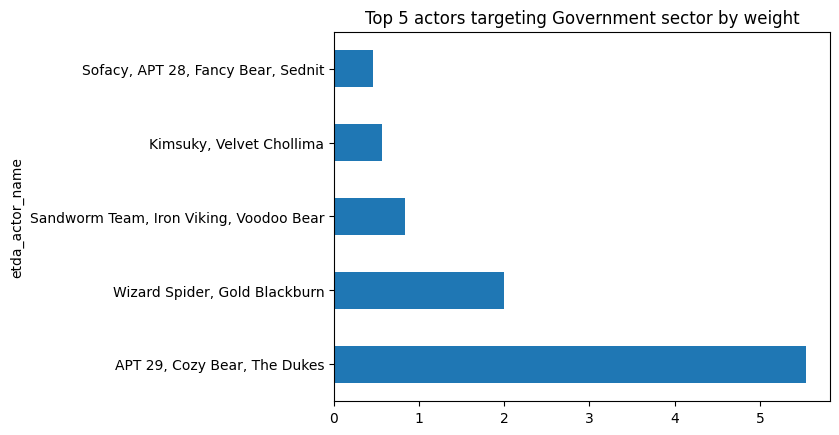

In [119]:
actor_weights = actors_ranked['actor_weight']
actor_weights.nlargest(5).plot(kind='barh',title="Top 5 actors targeting {} sector by weight".format(SECTOR))

In [120]:
actor_weights.drop_duplicates().head(5)

etda_actor_name
APT 29, Cozy Bear, The Dukes                             5.545455
Aquatic Panda                                            0.448485
Emissary Panda, APT 27, LuckyMouse, Bronze Union         0.000000
Kimsuky, Velvet Chollima                                 0.566667
Magic Hound, APT 35, Cobalt Illusion, Charming Kitten    0.100000
Name: actor_weight, dtype: float64

### 2.2. Rank TTPs
#### 2.3.1 Explode dataframe per TTP
Explode the dataframe per TTP. Now a weighting calculation can be done per TTP, based on the information provided. Information includes the actor results (and kill chain phase).

For now: the actor weights are summed per TTP to obtain a ranking per TTP. 

In [121]:
actors_ttp_exploded = actors_ranked.explode('mitre_attack_ttps')

#### 2.3.2. Group by TTP and sum actor weights
Sum the actor weights.

In [122]:
actors_ttp_summed = actors_ttp_exploded.reset_index(drop=True)
ttps_ranked = actors_ttp_summed.groupby('mitre_attack_ttps').sum()
ttps_ranked.sort_values(by='actor_weight',ascending=False)

,actor_weight
mitre_attack_ttps,
T1027,10.872727
T1588.002,10.648485
T1059.003,10.581818
T1059.001,10.581818
T1082,10.318182
...,...
T1560.002,0.000000
T1070.005,0.000000
T1608.002,0.000000


#### 2.3.3 Enrich TTP information
Information from the ATT&CK data is used via the attackcti package.

In [123]:
from attackcti import attack_client
from pandas import json_normalize
import sys

mitre_columns = ['technique_id','technique','kill_chain_phases','id','tactic','technique_detection','impact_type']

def get_attck_dataframe(matrix = 'enterprise'):
    if  (matrix.lower() == 'enterprise'):
        # Instantiating attack_client class
        lift = attack_client()
        # Getting techniques for windows platform - enterprise matrix
        attck = lift.get_enterprise_techniques(stix_format = False)
        # Generating a dataframe with information collected
        attck = json_normalize(attck)
        return attck
    else:
        sys.exit('ERROR: Only Enterprise available!!')

attck = get_attck_dataframe()
attck = attck[mitre_columns]

ttps_enriched = pd.merge(ttps_ranked,attck,how='left',left_index=True,right_on='technique_id')
ttps_enriched.index = ttps_ranked.index

[taxii2client.v20] [WARNING ] [2023-03-10 17:41:21,898] TAXII Server Response did not include 'Content-Range' header - results could be incomplete.
[taxii2client.v20] [WARNING ] [2023-03-10 17:41:21,923] TAXII Server Response with different amount of objects! Setting per_request=737


#### 2.3.4. Calculate weights

In [124]:
ttps_enriched['ttp_weight'] = ttps_enriched['actor_weight']

#### Statistics

<Axes: title={'center': 'Top 10 techniques for actors targeting Government sector'}, ylabel='technique'>

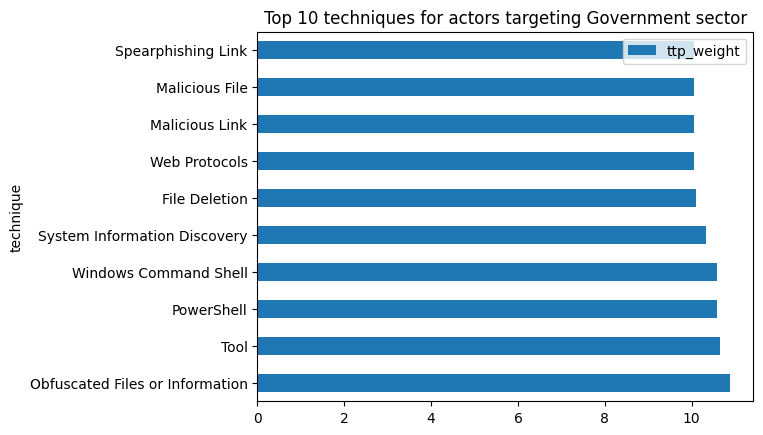

In [125]:
ttps_enriched.nlargest(10,columns='ttp_weight').plot.barh(y='ttp_weight',x='technique',title="Top 10 techniques for actors targeting {} sector".format(SECTOR))

## 3. Control prioritization